In [31]:
import numpy as np
import math
import sys
import time
from collections import OrderedDict

from itertools import product

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler

# progress bar
# from tqdm.notebook import tqdm
from tqdm import tqdm, trange

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# midi file creation
from mingus.containers import Note
from mingus.midi import fluidsynth
from mingus.containers import Bar, Track, Composition
from mingus.midi import midi_file_out

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4, suppress=True,linewidth=np.nan)
torch.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(precision=4, sci_mode=False)

In [32]:
# gpu if available (global variable for convenience)
device = torch.device("cpu")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data

## Contrapunctus XIV data / JSB Chorales Dataset / JS Fake Chorales

In [159]:
# # load data, 4 voices of instruments
# voices = np.loadtxt("input/contrapunctusXIV.txt")

# # remove starting silence, does not promote learning
# # data shape is (3816, 4) after
# voices = np.delete(voices, slice(8), axis=0)
# print("Data shape (4 voices):", voices.shape)
# print(voices[1242:1258])
# # print(voices[1242:1258, 0])
# print(len(voices))
# ------------------------------------------------------------------------
# # load data
# jsbChorales = np.load('input/Jsb16thSeparated.npz', allow_pickle=True, encoding='latin1')

# # get files
# for file in jsbChorales.files:
#     print(file)
#     print(jsbChorales[file].shape)

# print(jsbChorales["train"][0][0:10])
# print(len(jsbChorales["train"][0]))
# ------------------------------------------------------------------------
jsFakeChorales = np.load('input/js-fakes-16thSeparated.npz', allow_pickle=True, encoding='latin1')

# get files
for file in jsFakeChorales.files:
    print(file)
    print(jsFakeChorales[file].shape)

print(jsFakeChorales["pitches"][0][0:10])
print(len(jsFakeChorales["pitches"][0]))

Data shape (4 voices): (3804, 4)
[[61. 55. 52. 47.]
 [61. 55. 52. 47.]
 [61. 55. 49. 47.]
 [61. 55. 49. 47.]
 [61. 55. 49. 47.]
 [61. 55. 49. 47.]
 [73. 54. 54. 46.]
 [73. 54. 54. 46.]
 [73. 54. 54. 46.]
 [73. 54. 54. 46.]
 [73. 54. 52. 46.]
 [73. 54. 52. 46.]
 [73. 54. 52. 46.]
 [73. 54. 52. 46.]
 [66. 54. 52. 47.]
 [66. 54. 52. 47.]]
3804


# Data augmentation

Credit to the Bachelor thesis by ***Aulon Kuqi: "Art in Echo State Networks: Music Generation.", Jacobs University. 2017***, where Kuqi determines the best representation of musical data.

In [36]:
# pitch representation scaled to equal distances between chroma and circle of fifths
def pitchEncoding(midi_note, min_note, max_note):
    # n gives distance in semitones of the midi note to A4 (midi = 69)
    # A4 has frequency 440hz, which we use to calc the note freq
    n = midi_note - 69
    freq = np.power(2, (n / 12)) * 440

    # calc min and max pitch
    min_pitch = 2 * np.log2(np.power(2, ((min_note - 69) / 12)) * 440)
    max_pitch = 2 * np.log2(np.power(2, ((max_note - 69) / 12)) * 440)

    # scale such that distance of 1 octave in the first dimension, 
    #   is equal to opposite sides of the chroma/fifth circles
    encoded_pitch = 2 * np.log2(freq) - max_pitch + (max_pitch - min_pitch)/2

    return encoded_pitch

# function to calculate the chroma circle representation of a note
def chromaCircleEncoding(note):
    # chroma circle note positions are 1 to 12 followed
    chroma = list(range(1, 13))

    # calc circle angle
    theta = (chroma[note] - 1) * 30 # 360/12

    # calc x and y
    x = np.cos(theta)
    y = np.sin(theta)

    return x, y

# Function to calculate the circle of fifths representation of a note
def circleOfFifthsEncoding(note):
    # c of fifths note positions are more chaotic 
    c_of_5 = [1, 8, 3, 10, 5, 12, 7, 2, 9, 4, 11, 6]

    # calc circle angle
    theta = (c_of_5[note] - 1) * 30 # 360/12

    # calc x and y
    x = np.cos(theta)
    y = np.sin(theta)

    return x, y

# function to calculate the chroma and circle of fifths representations of a note
def calcEncoding(midi_note, min_note, max_note):
    # midi value of note to actual note
    note = int(((midi_note - 55) % 12))

    chroma_x, chroma_y = chromaCircleEncoding(note)
    fifths_x, fifths_y = circleOfFifthsEncoding(note)
    pitch = pitchEncoding(midi_note, min_note, max_note)

    return [pitch, chroma_x, chroma_y, fifths_x, fifths_y]

## Each note is encoded as its pitch value, values on the circle of fifths and chroma circle, thus 5 values in total.

In [38]:
def createEncodedData(voices):
    # create new shape of data
    encoded_voices = np.zeros((voices.shape[0], voices.shape[1] * 5), dtype=np.float32)

    # min, max of all notes, ignoring 0's
    min_note = np.min(voices[np.nonzero(voices)])
    max_note = np.max(voices[np.nonzero(voices)])

    for i, voice in enumerate([voices[:,0], voices[:,1], voices[:,2], voices[:,3]]):
        for j, note in enumerate(voice):
            # if silence
            if (note == 0):                
                encoded_voices[j, i*5:i*5+5] = [0., 0., 0., 0., 0.]
            # else note
            else:
                encoded_voices[j, i*5:i*5+5] = calcEncoding(note, min_note, max_note)

    return encoded_voices

## Create the encoded data

In [39]:
encoded_voices = createEncodedData(voices)
print(encoded_voices.shape)
print(encoded_voices[130:140])

(3804, 20)
[[ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.3333 -0.9912 -0.1324  0.6993 -0.7149 -0.3333 -0.8839  0.4677  0.1543 -0.988 ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.3333 -0.9912 -0.1324  0.6993 -0.7149 -0.3333 -0.8839  0.4677  0.1543 -0.988 ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.3333 -0.9912 -0.1324  0.6993 -0.7149 -0.5    -0.5985 -0.8012 -0.5985 -0.8012]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.3333 -0.9912 -0.1324  0.6993 -0.7149 -0.5    -0.5985 -0.8012 -0.5985 -0.8012]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.3333 -0.9912 -0.1324  0.6993 -0.7149 -0.5    -0.5985 -0.8012 -0.5985 -0.8012]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.3333 -0.9912 -0.1324  0.6993 -0.7149 -0.5    -0.5985 -0.8012 -0.5985 -0.8012]
 [ 0.      

## Creating custom dataset
### First, a one hot encode function for the target values, with an function that returns the location of the value in the set of uniques.'
The target values are a one hot encoding of each voice target value, one for each task, where a task is the prediciton of the next notes for a single voice.

In [40]:
# to find float index in unique float list of standard scaled array
# works also for ints when not scaled
def uniqueLocation(uniques:list, note:float) -> int:
    for index, unique in enumerate(uniques):
        if (math.isclose(unique, note, abs_tol=0.0001)):
            return index
    return None

In [41]:
# find unique notes in a set of voices
def findUniques(voices:np.ndarray) -> list:
    uniques = []

    # for each voice
    for voice in voices.T:
        unique_notes = np.unique(voice)
        uniques.append(unique_notes)
    
    return uniques

In [42]:
# find unique note union of all sequences that are prepared for the dataloader
def findUniquesSequences(sequences):
    print(sequences.shape)
    pass
    
    # # loop through sequences
    # for sequence in sequences:
    #     unique_notes = findUniques(sequence)
    #     # union of lists, removing duplicates

In [43]:
# returns concatenated onehot encoding for each note 
def one_hot_encode(y: np.ndarray, uniques:list) -> np.ndarray:
    # initialize return arrays
    one_hot_voice1 = np.zeros((y.shape[0], len(uniques[0])), dtype=np.float32)
    one_hot_voice2 = np.zeros((y.shape[0], len(uniques[1])), dtype=np.float32)
    one_hot_voice3 = np.zeros((y.shape[0], len(uniques[2])), dtype=np.float32)
    one_hot_voice4 = np.zeros((y.shape[0], len(uniques[3])), dtype=np.float32)
    
    # one hot encode each note
    for timestep, notes in enumerate(y):
        for voice, note in enumerate(notes):
            if (voice == 0):
                # get location in uniques of current note
                one_hot_location = uniqueLocation(uniques[0], note)
                one_hot_voice1[timestep][one_hot_location] = 1
            elif (voice == 1):
                one_hot_location = uniqueLocation(uniques[1], note)
                one_hot_voice2[timestep][one_hot_location] = 1
            elif (voice == 2):
                one_hot_location = uniqueLocation(uniques[2], note)
                one_hot_voice3[timestep][one_hot_location] = 1
            elif (voice == 3):
                one_hot_location = uniqueLocation(uniques[3], note)
                one_hot_voice4[timestep][one_hot_location] = 1

    return one_hot_voice1, one_hot_voice2, one_hot_voice3, one_hot_voice4

### Note the number of uniques for each voice, these numbers are used in the final layers of the different task heads when initializing the model

In [45]:
uniques = findUniques(voices)
print(uniques)
print(f"Voice 1 uniques: {len(uniques[0])}\nVoice 2 uniques: {len(uniques[1])}\nVoice 3 uniques: {len(uniques[2])}\nVoice 4 uniques: {len(uniques[3])}")

[array([ 0., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 71., 73., 74., 76.]), array([ 0., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 71.]), array([ 0., 40., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62.]), array([ 0., 28., 30., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54.])]
Voice 1 uniques: 22
Voice 2 uniques: 27
Voice 3 uniques: 23
Voice 4 uniques: 26


### Custom dataset consisting of a window of notes, and target values of concatenated one hot encoded vectors of the voices

In [47]:
# encoded voices used as input data (x), non_encoded_voices as target data (y), 
#   voices used to one hot encode (necessary for nr of uniques in data), 
#   as encoded and non_encoded is a train/test subset of the complete set and might miss some unique values 
class NotesDataset(Dataset):
    def __init__(self, window_size:int, skip_steps:int, input_size:int, uniques:list):
        # keep window size and skip steps consistent for each sequence
        self.window_size = window_size
        self.skip_steps = skip_steps
        # make sure every sequence has same shape
        self.input_size = input_size
        self.uniques = uniques

        # init nr_samples as 0
        self.nr_samples = 0

        # init tensors
        # self.x = torch.empty((1, self.window_size, input_size), dtype=torch.float32).to(device)
        self.x = torch.empty((0, window_size, input_size), dtype=torch.float32).to(device)
        self.y1 = torch.empty((0, len(uniques[0])), dtype=torch.float32).to(device)
        self.y2 = torch.empty((0, len(uniques[1])), dtype=torch.float32).to(device)
        self.y3 = torch.empty((0, len(uniques[2])), dtype=torch.float32).to(device)
        self.y4 = torch.empty((0, len(uniques[3])), dtype=torch.float32).to(device)

    # add sequences through this function, which allows the dataset to store multiple sequences in sliding window fashion (with skip steps)
    def addSequence(self, encoded_voices:np.ndarray, non_encoded_voices:np.ndarray):
        # nr of samples, and nr of voices
        nr_samples = encoded_voices.shape[0] - self.window_size
        input_width = encoded_voices.shape[1]
        output_width = non_encoded_voices.shape[1]

        # shape check for input
        if (self.input_size != input_width):
            raise ValueError(f"Added sequence input dimensions do not match with initialized ({self.input_size} != {input_width})")

        # initialize x data -> window_size amount of notes of 4 (=20 when encoded) voices each per prediction
        x = np.zeros((nr_samples, self.window_size, input_width), dtype=np.float32)
        for i in range(x.shape[0]):
            x[i] = encoded_voices[i : i + self.window_size]

        # initialize y data -> 4 following target notes per time window 
        y = np.zeros((nr_samples, output_width), dtype = np.float32)
        for j in range(y.shape[0]):
            y[j] = non_encoded_voices[j + self.window_size]

        # one hot encode different task (differnt voices) target values
        y1, y2, y3, y4 = one_hot_encode(y, self.uniques)

        # create tensors
        self.x = torch.cat((self.x, torch.from_numpy(x).to(device)), 0)
        self.y1 = torch.cat((self.y1, torch.from_numpy(y1).to(device)), 0)
        self.y2 = torch.cat((self.y2, torch.from_numpy(y2).to(device)), 0)
        self.y3 = torch.cat((self.y3, torch.from_numpy(y3).to(device)), 0)
        self.y4 = torch.cat((self.y4, torch.from_numpy(y4).to(device)), 0)

        # add nr of samples to total
        self.nr_samples += nr_samples

    def __getitem__(self, index: int):
        sample = {'x': self.x[index], 'y1': self.y1[index], 'y2': self.y2[index], 'y3': self.y3[index], 'y4': self.y4[index]}
        return sample

    def __len__(self):
        return self.nr_samples

### Function to create the test and train dataloader from the custom dataset

In [48]:
# create train and test dataset based on window size where one window of timesteps
#   will predict the subsequential single timestep
# Data is created without any information leak between test/train (either scaling leak or time leak)
def createDataLoadersSequences(sequences, encoded_voices, split_size, window_size, skip_steps, batch_size):
    # get unique notes for each voices, for one-hot-encoding/output size
    uniques = findUniquesSequences(sequences)
    
# create train and test dataset based on window size where one window of timesteps
#   will predict the subsequential single timestep
# Data is created without any information leak between test/train (either scaling leak or time leak)
def createDataLoaders(voices, encoded_voices, split_size, window_size, skip_steps, batch_size):
    # get unique notes for each voices, for one-hot-encoding/output size
    uniques = findUniques(voices)
    
    # Train/test split
    dataset_size = voices.shape[0]
    indices = list(range(dataset_size))
    split = int(np.floor((1 - split_size) * dataset_size))
    train_indices, test_indices = indices[:split], indices[split:]

    # create split in data, using encoded data for x (input), and non encoded for y (target)
    train_voices_x = encoded_voices[train_indices, :]
    train_voices_y = voices[train_indices, :]
    test_voices_x = encoded_voices[test_indices, :]
    test_voices_y = voices[test_indices, :]
    
    # scale both sets, using training data as fit (no leaks)
    scaler = StandardScaler()
    scaler.fit(train_voices_x)
    train_voices_x = scaler.transform(train_voices_x)
    # all_voices = scaler.transform(voices)
    
    # set input/output sizes
    input_size = encoded_voices.shape[1]
    output_sizes = [len(uniques[0]), len(uniques[1]), len(uniques[2]), len(uniques[3])]
    
    # create train dataset
    train_dataset = NotesDataset(window_size, skip_steps, input_size, uniques)
    train_dataset.addSequence(train_voices_x, train_voices_y)

    # create train dataloader
    train_loader = DataLoader(train_dataset, batch_size)

    # Do the same for test set 
    if (split_size > 0):
        # scale test set
        test_voices_x = scaler.transform(test_voices_x)
        # create test dataset
        test_dataset = NotesDataset(window_size, skip_steps, input_size, uniques)
        test_dataset.addSequence(test_voices_x, test_voices_y)

        # create test dataloader
        test_loader = DataLoader(test_dataset, batch_size)
    else:
        test_loader = None
    
    return train_loader, test_loader

# Model definition
The model consists of a double LSTM layer, followed by four task heads, one for each of the voice outputs. Dropout frequency has been tuned for best results, along with weight decay (L2 regularization) to keep the model from becoming too complex while still learning meaningful patterns in the limited data.

In [246]:
# LSTM model with four output heads, one for each voice next note prediction (task)
# The model can be set to stateful, meaning the internal hidden state and cell state is passed
#   into the model each batch and reset once per epoch.
class LSTM_model(nn.Module):
    def __init__(self, input_size, output_sizes, hidden_size, num_layers, batch_size):
        super(LSTM_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # lstm layer(s)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # task head: voice 1-4
        self.heads = nn.ModuleList([
            nn.Sequential(OrderedDict([
                ('linear', nn.Linear(hidden_size, hidden_size)),
                ('relu', nn.ReLU()),
                ('dropout', nn.Dropout(0.5)),
                ('final', nn.Linear(hidden_size, output_size))
            ])) for output_size in output_sizes
        ])

        print("LSTM initialized with {} input size, {} hidden layer size, {} number of LSTM layers, and an output size of {}".format(input_size, hidden_size, num_layers, output_sizes))
        # reset states in case of stateless use
        self.reset_states(batch_size)

    # reset hidden state and cell state, should be before each new sequence
    #   In our problem: every epoch, as it is one long sequence
    def reset_states(self, batch_size):
    # def reset_states(self):
        # hidden state and cell state for LSTM 
        self.hn = torch.zeros(self.num_layers,  batch_size, self.hidden_size).to(device)
        self.cn = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

    def forward(self, input, stateful):
        # simple forward function
        # stateful = keep hidden states entire sequence length
        # only use when 2 samples follow temporally (first timepoint from 2nd sample follows from last timepoint 1st sample)
        if stateful:
            # for last batch which might not be the same shape
            if (input.size(0) != self.hn.size(1)):
                self.reset_states(input.size(0))
              
            # lstm layer
            out, (self.hn, self.cn) = self.lstm(input, (self.hn.detach(), self.cn.detach())) 

        else:
            # initiaze hidden and cell states
            self.reset_states(input.size(0))  
            # lstm layer
            out, (hn, cn) = self.lstm(input, (hn, cn))
        
        # linear output layers for each head
        outputs = [head(out[:,-1,:]) for head in self.heads]

        return outputs

# Training loop

In [224]:
def training(model, train_loader:DataLoader, test_loader:DataLoader, nr_epochs, optimizer, loss_func, scheduler, stateful, writer):
    # lowest train/test loss, train/test loss lists
    lowest_train_loss = np.inf
    lowest_test_loss = np.inf
    train_losses = []
    test_losses = []

    # test_loss declaration untill assigned in model evaluation (used in progress bar print)
    test_loss = "n/a"

    # training loop
    for epoch in (progress_bar := tqdm(range(1, nr_epochs))):
        # add epoch info to progress bar
        progress_bar.set_description(f"Epoch {epoch}")

        # reset lstm hidden and cell state (stateful lstm = reset states once per sequence)
        # if not, reset automatically each forward call
        if stateful:
            model.reset_states(train_loader.batch_size)

        # reset running loss
        running_loss_train = 0
        running_loss_test = 0

        # train loop
        model.train()
        for data in train_loader:
            # reset gradient function of weights
            optimizer.zero_grad()
            # forward
            voice1_pred, voice2_pred, voice3_pred, voice4_pred = model(data["x"], stateful)
            # calculate loss
            loss = loss_func(voice1_pred, data["y1"]) + loss_func(voice2_pred, data["y2"]) + loss_func(voice3_pred, data["y3"]) + loss_func(voice4_pred, data["y4"])
            # backward, retain_graph = True needed for hidden lstm states
            loss.backward(retain_graph=True)
            # step
            optimizer.step()
            # add to running loss
            running_loss_train += loss.item()

        # learning rate scheduler step
        scheduler.step()

        # calc running loss
        train_loss = running_loss_train/len(train_loader)
        train_losses.append(train_loss)

        # add loss to tensorboard
        writer.add_scalar("Running train loss", train_loss, epoch)        

        # check if lowest loss
        if (train_loss < lowest_train_loss):
            # Save model
            torch.save(model.state_dict(), "models/model" + str(train_loader.dataset.x.shape[1]) + str(model.hidden_size) + ".pth")
            # torch.save(model.state_dict(), "drive/MyDrive/colab_outputs/lstm_bach/models/model" + str(train_loader.dataset.x.shape[1]) + str(model.hidden_size) + ".pth")

        # Test evaluation
        if (test_loader):
            # model.eval()
            with torch.no_grad():
                for data in test_loader:
                    # forward pass
                    voice1_pred, voice2_pred, voice3_pred, voice4_pred = model(data["x"], stateful)
                    # calculate loss
                    loss = loss_func(voice1_pred, data["y1"]) + loss_func(voice2_pred, data["y2"]) + loss_func(voice3_pred, data["y3"]) + loss_func(voice4_pred, data["y4"])
                    # add to running loss
                    running_loss_test += loss.item()

            # calc running loss
            test_loss = running_loss_test/len(test_loader)
            test_losses.append(test_loss)

            # add test loss to tensorboard
            writer.add_scalar("Running test loss", test_loss, epoch)

            # if lowest till now, save model (checkpointing)
            if (test_loss < lowest_test_loss):
                torch.save(model.state_dict(), "models/model" + str(train_loader.dataset.x.shape[1]) + str(model.hidden_size) + "test" + ".pth")
                # torch.save(model.state_dict(), "drive/MyDrive/colab_outputs/lstm_bach/models/model" + str(train_loader.dataset.x.shape[1]) + str(model.hidden_size) + "test" + ".pth")

        # before next epoch: add last epoch info to progress bar
        progress_bar.set_postfix({"train_loss": train_loss, "test_loss": test_loss})

    return train_losses, test_losses

## Hyperparamers
The hyperparameters dictionary acts as a grid search if multiple values for the parameters are given.

In [225]:
base1_train_losses_001 = []
base1_test_losses_001 = []
base1_train_losses_01 = []
base1_test_losses_01 = []

In [231]:
fine2_train_losses_01 = []
fine2_test_losses_01 = []
fine2_train_losses_06 = []
fine2_test_losses_06 = []
fine2_train_losses_1 = []
fine2_test_losses_1 = []

In [64]:
base_train_losses_001 = []
base_test_losses_001 = []
base_train_losses_01 = []
base_test_losses_01 = []

fine_train_losses_01 = []
fine_test_losses_01 = []
fine_train_losses_06 = []
fine_test_losses_06 = []
fine_train_losses_1 = []
fine_test_losses_1 = []
att_train_losses_06 = []
att_test_losses_06 = []

In [258]:
att_train_losses_01 = []
att_test_losses_01 = []
att_train_losses_1 = []
att_test_losses_1 = []

In [226]:
# batch_size for training network
batch_size = 16

# split size of test/train data
split_size = 0.1

# hyperparameters for fine-tuning
    # window_size = sliding window on time-sequence data for input
    # skip steps = steps the window slides each time
    # hidden_size = hidden units of lstm layer(s)
    # conv_channels = number of channels in the first conv layer (multiplied by 2 every next layer)
    # nr_layers = number of lstm layers stacked after each other
hyperparams = dict(
    window_size = [16],
    skip_steps = [16],
    hidden_size = [16],
    nr_layers = [1],
    l2 = [0.001, 0.01]
)
# sets of combinations of hparams
hyperparam_value_sets = product(*[value for value in hyperparams.values()])

# Loop through different combinations of the hyperparameters
count = 1
for run_id, (window_size, skip_steps, hidden_size, nr_layers, l2) in enumerate(hyperparam_value_sets):
    # tensorboard summary writer
    writer = SummaryWriter(f'runs/E_window_size={window_size}_hidden_size={hidden_size}_l2={l2}')
    # writer = SummaryWriter(f'drive/MyDrive/colab_outputs/lstm_bach/runs/window_size={window_size}_hidden_size={hidden_size}_l2={l2}')

    # Split data in train and test, scale, create datasets and create dataloaders
    train_loader, test_loader = createDataLoaders(voices, encoded_voices, split_size, window_size, skip_steps, batch_size)

    # some informational print statements
    print("\nNew run window/hidden/l2/batch_size:", window_size, "/", hidden_size, "/", l2, "/", batch_size)
    data = next(iter(train_loader))
    print("Input size:", data["x"].size(), 
        "- Output size:[", data["y1"].size(), data["y2"].size(), data["y3"].size(), data["y4"].size(), "]\n",
        "TRAIN batches:", len(train_loader), 
        "- TEST batches:", len(test_loader) if test_loader else "Not available")
    # Input/output dimensions
    input_size = encoded_voices.shape[1]
    output_sizes = [data["y1"].size(1), data["y2"].size(1), data["y3"].size(1), data["y4"].size(1)]

    print("Input size:",input_size, "Output size:",output_sizes)
    # create model
    lstm_model = LSTM_model(input_size, output_sizes, hidden_size, nr_layers, batch_size)

    # loss function and optimizer
    # Output of each head is multi-class classification -> cross entropy
    loss_func = nn.CrossEntropyLoss()
    # AdamW = Adam with fixed weight decay (weight decay performed after controlling parameter-wise step size)
    optimizer = optim.AdamW(lstm_model.parameters(), lr=0.001, weight_decay=l2)
    scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=750)
    
    # to gpu if possible
    lstm_model = lstm_model.to(device)
    
    # training loop
    epochs = 100
    
    # In this example we should not use a stateful lstm, as the next samples (subsequent sliding windows) do not follow directly from the current.
    # This is only the case when the first sample is (for Ex.) [1:10] which is the first window, and [11:20] the next, and so on.
    # With our data it would be: [1:10] and the next [2:11]. Target value does not matter necessarily. 
    # More explanation: https://stackoverflow.com/questions/58276337/proper-way-to-feed-time-series-data-to-stateful-lstm
    #   unfortunately I implemented stateful before knowing these in and outs.
    # One possible way to use stateful is to use window_size = 1
    stateful = True
    train_losses, test_losses = training(lstm_model, train_loader, test_loader, epochs, optimizer, loss_func, scheduler, stateful, writer)

    if count == 1:
        base1_train_losses_001 = train_losses
        base1_test_losses_001 = test_losses
    else:
        base1_train_losses_01 = train_losses
        base1_test_losses_01 = test_losses
    
    count+=1
    # flush tensorboard writer
    writer.flush()


New run window/hidden/l2/batch_size: 16 / 16 / 0.001 / 16
Input size: torch.Size([16, 16, 20]) - Output size:[ torch.Size([16, 22]) torch.Size([16, 27]) torch.Size([16, 23]) torch.Size([16, 26]) ]
 TRAIN batches: 213 - TEST batches: 23
Input size: 20 Output size: [22, 27, 23, 26]
LSTM initialized with 20 input size, 16 hidden layer size, 1 number of LSTM layers, and an output size of [22, 27, 23, 26]


Epoch 99: 100%|██████████| 99/99 [01:29<00:00,  1.10it/s, train_loss=5.14, test_loss=8.22]



New run window/hidden/l2/batch_size: 16 / 16 / 0.01 / 16
Input size: torch.Size([16, 16, 20]) - Output size:[ torch.Size([16, 22]) torch.Size([16, 27]) torch.Size([16, 23]) torch.Size([16, 26]) ]
 TRAIN batches: 213 - TEST batches: 23
Input size: 20 Output size: [22, 27, 23, 26]
LSTM initialized with 20 input size, 16 hidden layer size, 1 number of LSTM layers, and an output size of [22, 27, 23, 26]


Epoch 99: 100%|██████████| 99/99 [01:27<00:00,  1.14it/s, train_loss=5.24, test_loss=8.32]


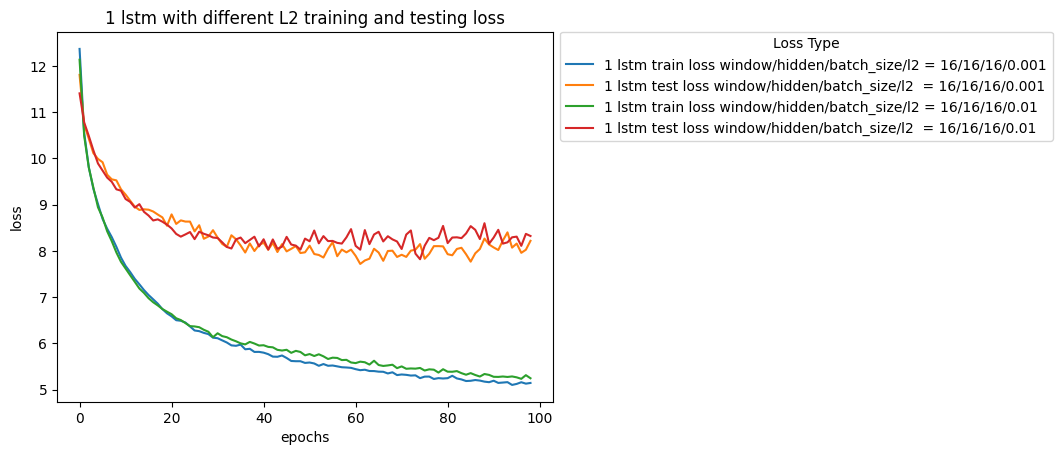

In [284]:
# quick plots
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_losses and test_losses are lists or arrays of loss values
sns.lineplot(data=base1_train_losses_001, label='1 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.001')
sns.lineplot(data=base1_test_losses_001, label='1 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.001')
sns.lineplot(data=base1_train_losses_01, label='1 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.01')
sns.lineplot(data=base1_test_losses_01, label='1 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.01')

# Adding legends, labels and title
plt.legend(title='Loss Type', loc='upper left', bbox_to_anchor=(1, 1.02), frameon=True)
plt.xlabel('epochs')  # Assuming each point represents an epoch
plt.ylabel('loss')
plt.title('1 lstm with different L2 training and testing loss')
plt.savefig('my_plot1.png', bbox_inches='tight')

plt.show()

In [66]:
# batch_size for training network
batch_size = 16

# split size of test/train data
split_size = 0.1

# hyperparameters for fine-tuning
# window_size = sliding window on time-sequence data for input
# skip steps = steps the window slides each time
# hidden_size = hidden units of lstm layer(s)
# conv_channels = number of channels in the first conv layer (multiplied by 2 every next layer)
# nr_layers = number of lstm layers stacked after each other
hyperparams = dict(
    window_size = [16],
    skip_steps = [16],
    hidden_size = [16],
    nr_layers = [2],
    l2 = [0.001, 0.01]
)
# sets of combinations of hparams
hyperparam_value_sets = product(*[value for value in hyperparams.values()])

In [67]:
# Loop through different combinations of the hyperparameters
count = 1
for run_id, (window_size, skip_steps, hidden_size, nr_layers, l2) in enumerate(hyperparam_value_sets):
    # tensorboard summary writer
    writer = SummaryWriter(f'runs/E_window_size={window_size}_hidden_size={hidden_size}_l2={l2}')
    # writer = SummaryWriter(f'drive/MyDrive/colab_outputs/lstm_bach/runs/window_size={window_size}_hidden_size={hidden_size}_l2={l2}')

    # Split data in train and test, scale, create datasets and create dataloaders
    train_loader, test_loader = createDataLoaders(voices, encoded_voices, split_size, window_size, skip_steps, batch_size)

    # some informational print statements
    print("\nNew run window/hidden/l2/batch_size:", window_size, "/", hidden_size, "/", l2, "/", batch_size)
    data = next(iter(train_loader))
    print("Input size:", data["x"].size(), 
        "- Output size:[", data["y1"].size(), data["y2"].size(), data["y3"].size(), data["y4"].size(), "]\n",
        "TRAIN batches:", len(train_loader), 
        "- TEST batches:", len(test_loader) if test_loader else "Not available")
    # Input/output dimensions
    input_size = encoded_voices.shape[1]
    output_sizes = [data["y1"].size(1), data["y2"].size(1), data["y3"].size(1), data["y4"].size(1)]

    print("Input size:",input_size, "Output size:",output_sizes)
    # create model
    lstm_model = LSTM_model(input_size, output_sizes, hidden_size, nr_layers, batch_size)

    # loss function and optimizer
    #   Output of each head is multi-class classification -> cross entropy
    loss_func = nn.CrossEntropyLoss()
    # AdamW = Adam with fixed weight decay (weight decay performed after controlling parameter-wise step size)
    optimizer = optim.AdamW(lstm_model.parameters(), lr=0.001, weight_decay=l2)
    scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=750)
    
    # to gpu if possible
    lstm_model = lstm_model.to(device)
    
    # training loop
    epochs = 1000
    
    # In this example we should not use a stateful lstm, as the next samples (subsequent sliding windows) do not follow directly from the current.
    # This is only the case when the first sample is (for Ex.) [1:10] which is the first window, and [11:20] the next, and so on.
    # With our data it would be: [1:10] and the next [2:11]. Target value does not matter necessarily. 
    # More explanation: https://stackoverflow.com/questions/58276337/proper-way-to-feed-time-series-data-to-stateful-lstm
    #   unfortunately I implemented stateful before knowing these in and outs.
    # One possible way to use stateful is to use window_size = 1
    stateful = True
    train_losses, test_losses = training(lstm_model, train_loader, test_loader, epochs, optimizer, loss_func, scheduler, stateful, writer)

    if count == 1:
        base_train_losses_001 = train_losses
        base_test_losses_001 = test_losses
    else:
        base_train_losses_01 = train_losses
        base_test_losses_01 = test_losses
    
    count+=1
    # flush tensorboard writer
    writer.flush()


New run window/hidden/l2/batch_size: 16 / 16 / 0.001 / 16
Input size: torch.Size([16, 16, 20]) - Output size:[ torch.Size([16, 22]) torch.Size([16, 27]) torch.Size([16, 23]) torch.Size([16, 26]) ]
 TRAIN batches: 213 - TEST batches: 23
Input size: 20 Output size: [22, 27, 23, 26]
LSTM initialized with 20 input size, 16 hidden layer size, 2 number of LSTM layers, and an output size of [22, 27, 23, 26]


Epoch 99: 100%|██████████| 99/99 [01:44<00:00,  1.05s/it, train_loss=5.4, test_loss=10.2] 



New run window/hidden/l2/batch_size: 16 / 16 / 0.01 / 16
Input size: torch.Size([16, 16, 20]) - Output size:[ torch.Size([16, 22]) torch.Size([16, 27]) torch.Size([16, 23]) torch.Size([16, 26]) ]
 TRAIN batches: 213 - TEST batches: 23
Input size: 20 Output size: [22, 27, 23, 26]
LSTM initialized with 20 input size, 16 hidden layer size, 2 number of LSTM layers, and an output size of [22, 27, 23, 26]


Epoch 99: 100%|██████████| 99/99 [01:41<00:00,  1.03s/it, train_loss=5.66, test_loss=10.2]


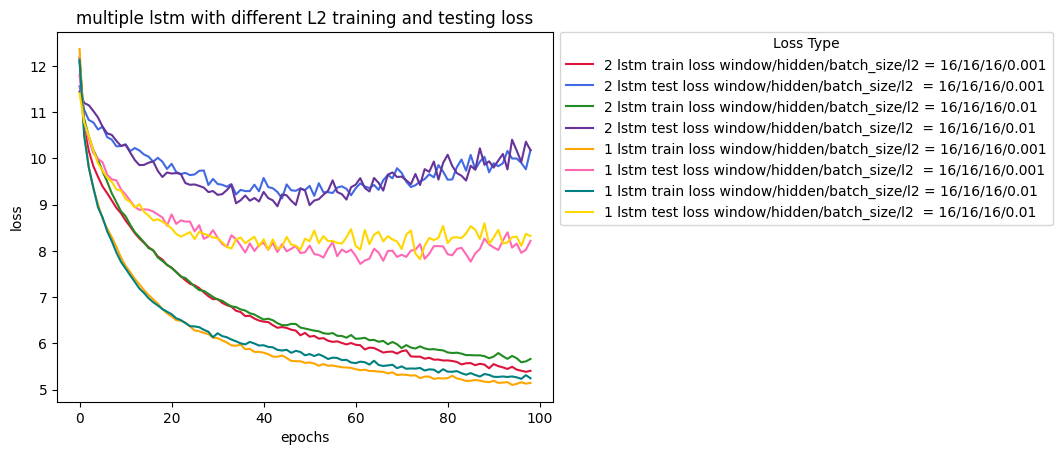

In [285]:
# quick plots
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_losses and test_losses are lists or arrays of loss values
sns.lineplot(data=base_train_losses_001, label='2 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.001',color="#DC143C")
sns.lineplot(data=base_test_losses_001, label='2 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.001',color="#4169E1")
sns.lineplot(data=base_train_losses_01, label='2 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.01',color="#228B22")
sns.lineplot(data=base_test_losses_01, label='2 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.01',color="#663399")
sns.lineplot(data=base1_train_losses_001, label='1 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.001',color='#FFA500')
sns.lineplot(data=base1_test_losses_001, label='1 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.001',color='#FF69B4')
sns.lineplot(data=base1_train_losses_01, label='1 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.01',color='#008080')
sns.lineplot(data=base1_test_losses_01, label='1 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.01',color='#FFD700')

# Adding legends, labels and title
plt.legend(title='Loss Type', loc='upper left', bbox_to_anchor=(1, 1.02), frameon=True)
plt.xlabel('epochs')  # Assuming each point represents an epoch
plt.ylabel('loss')
plt.title('multiple lstm with different L2 training and testing loss')
plt.savefig('my_plot2.png', bbox_inches='tight')

plt.show()

In [71]:
# batch_size for training network
batch_size = 32

# split size of test/train data
split_size = 0.1

# hyperparameters for fine-tuning
    # window_size = sliding window on time-sequence data for input
    # skip steps = steps the window slides each time
    # hidden_size = hidden units of lstm layer(s)
    # conv_channels = number of channels in the first conv layer (multiplied by 2 every next layer)
    # nr_layers = number of lstm layers stacked after each other
hyperparams = dict(
    window_size = [96],
    skip_steps = [16],
    hidden_size = [256],
    nr_layers = [2],
    l2 = [0.01, 0.06, 0.1]
)
# sets of combinations of hparams
hyperparam_value_sets = product(*[value for value in hyperparams.values()])

## Grid search loop
### Lowest test loss (early stopping) and lowest train loss models get saved to *models/* under naming based on the hyperparameters. 
Tensorboard is used to see loss curves.  

In [72]:
# Loop through different combinations of the hyperparameters
count = 1
for run_id, (window_size, skip_steps, hidden_size, nr_layers, l2) in enumerate(hyperparam_value_sets):
    # tensorboard summary writer
    writer = SummaryWriter(f'runs/E_window_size={window_size}_hidden_size={hidden_size}_l2={l2}')
    # writer = SummaryWriter(f'drive/MyDrive/colab_outputs/lstm_bach/runs/window_size={window_size}_hidden_size={hidden_size}_l2={l2}')

    # Split data in train and test, scale, create datasets and create dataloaders
    train_loader, test_loader = createDataLoaders(voices, encoded_voices, split_size, window_size, skip_steps, batch_size)

    # some informational print statements
    print("\nNew run window/hidden/l2/batch_size:", window_size, "/", hidden_size, "/", l2, "/", batch_size)
    data = next(iter(train_loader))
    print("Input size:", data["x"].size(), 
        "- Output size:[", data["y1"].size(), data["y2"].size(), data["y3"].size(), data["y4"].size(), "]\n",
        "TRAIN batches:", len(train_loader), 
        "- TEST batches:", len(test_loader) if test_loader else "Not available")
    # Input/output dimensions
    input_size = encoded_voices.shape[1]
    output_sizes = [data["y1"].size(1), data["y2"].size(1), data["y3"].size(1), data["y4"].size(1)]

    print("Input size:",input_size, "Output size:",output_sizes)
    # create model
    lstm_model = LSTM_model(input_size, output_sizes, hidden_size, nr_layers, batch_size)

    # loss function and optimizer
    #   Output of each head is multi-class classification -> cross entropy
    loss_func = nn.CrossEntropyLoss()
    # AdamW = Adam with fixed weight decay (weight decay performed after controlling parameter-wise step size)
    optimizer = optim.AdamW(lstm_model.parameters(), lr=0.001, weight_decay=l2)
    scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=750)
    
    # to gpu if possible
    lstm_model = lstm_model.to(device)
    
    # training loop
    epochs = 100
    
    # In this example we should not use a stateful lstm, as the next samples (subsequent sliding windows) do not follow directly from the current.
    # This is only the case when the first sample is (for Ex.) [1:10] which is the first window, and [11:20] the next, and so on.
    # With our data it would be: [1:10] and the next [2:11]. Target value does not matter necessarily. 
    # More explanation: https://stackoverflow.com/questions/58276337/proper-way-to-feed-time-series-data-to-stateful-lstm
    #   unfortunately I implemented stateful before knowing these in and outs.
    # One possible way to use stateful is to use window_size = 1
    stateful = True
    train_losses, test_losses = training(lstm_model, train_loader, test_loader, epochs, optimizer, loss_func, scheduler, stateful, writer)

    if count == 1:
        fine_train_losses_01 = train_losses
        fine_test_losses_01 = test_losses
    elif count == 2:
        fine_train_losses_06 = train_losses
        fine_test_losses_06 = test_losses
    else:
        fine_train_losses_1 = train_losses
        fine_test_losses_1 = test_losses
    
    count+=1
    # flush tensorboard writer
    writer.flush()


New run window/hidden/l2/batch_size: 96 / 256 / 0.01 / 32
Input size: torch.Size([32, 96, 20]) - Output size:[ torch.Size([32, 22]) torch.Size([32, 27]) torch.Size([32, 23]) torch.Size([32, 26]) ]
 TRAIN batches: 104 - TEST batches: 9
Input size: 20 Output size: [22, 27, 23, 26]
LSTM initialized with 20 input size, 256 hidden layer size, 2 number of LSTM layers, and an output size of [22, 27, 23, 26]


Epoch 99: 100%|██████████| 99/99 [2:40:31<00:00, 97.29s/it, train_loss=0.0101, test_loss=18]     



New run window/hidden/l2/batch_size: 96 / 256 / 0.06 / 32
Input size: torch.Size([32, 96, 20]) - Output size:[ torch.Size([32, 22]) torch.Size([32, 27]) torch.Size([32, 23]) torch.Size([32, 26]) ]
 TRAIN batches: 104 - TEST batches: 9
Input size: 20 Output size: [22, 27, 23, 26]
LSTM initialized with 20 input size, 256 hidden layer size, 2 number of LSTM layers, and an output size of [22, 27, 23, 26]


Epoch 99: 100%|██████████| 99/99 [30:31<00:00, 18.50s/it, train_loss=0.0149, test_loss=16]  



New run window/hidden/l2/batch_size: 96 / 256 / 0.1 / 32
Input size: torch.Size([32, 96, 20]) - Output size:[ torch.Size([32, 22]) torch.Size([32, 27]) torch.Size([32, 23]) torch.Size([32, 26]) ]
 TRAIN batches: 104 - TEST batches: 9
Input size: 20 Output size: [22, 27, 23, 26]
LSTM initialized with 20 input size, 256 hidden layer size, 2 number of LSTM layers, and an output size of [22, 27, 23, 26]


Epoch 99: 100%|██████████| 99/99 [33:20<00:00, 20.21s/it, train_loss=0.0501, test_loss=14]  


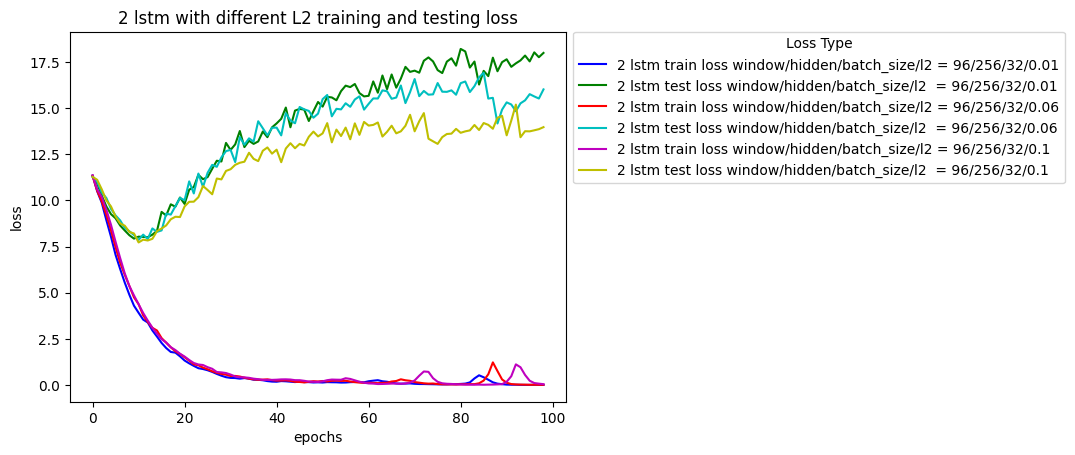

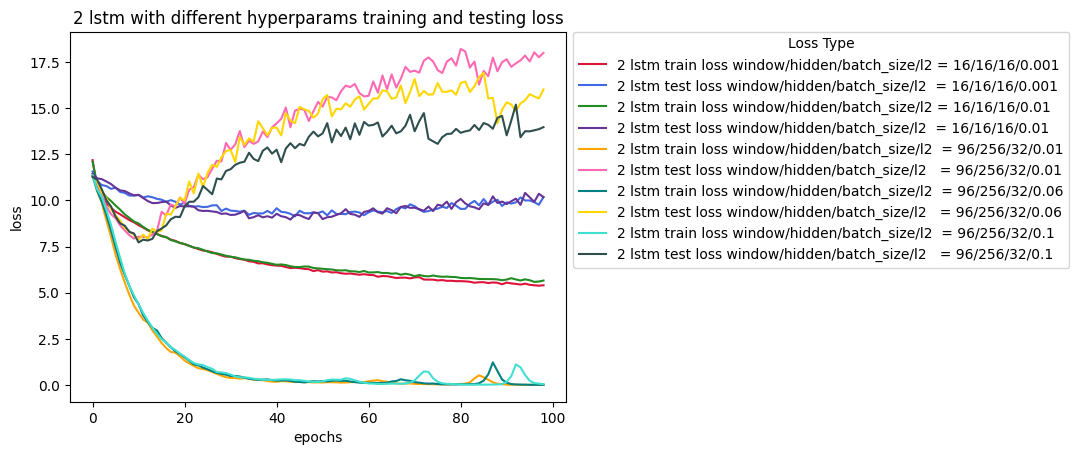

In [286]:
# quick plots
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_losses and test_losses are lists or arrays of loss values
sns.lineplot(data=fine_train_losses_01, label='2 lstm train loss window/hidden/batch_size/l2 = 96/256/32/0.01',color='b')
sns.lineplot(data=fine_test_losses_01, label='2 lstm test loss window/hidden/batch_size/l2  = 96/256/32/0.01',color='g')
sns.lineplot(data=fine_train_losses_06, label='2 lstm train loss window/hidden/batch_size/l2 = 96/256/32/0.06',color='r')
sns.lineplot(data=fine_test_losses_06, label='2 lstm test loss window/hidden/batch_size/l2  = 96/256/32/0.06',color='c')
sns.lineplot(data=fine_train_losses_1, label='2 lstm train loss window/hidden/batch_size/l2 = 96/256/32/0.1',color='m')
sns.lineplot(data=fine_test_losses_1, label='2 lstm test loss window/hidden/batch_size/l2  = 96/256/32/0.1',color='y')

# Adding legends, labels and title
plt.legend(title='Loss Type', loc='upper left', bbox_to_anchor=(1, 1.02), frameon=True)
plt.xlabel('epochs')  # Assuming each point represents an epoch
plt.ylabel('loss')
plt.title('2 lstm with different L2 training and testing loss')
plt.savefig('my_plot3.png', bbox_inches='tight')
plt.show()

sns.lineplot(data=base_train_losses_001, label='2 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.001',color='#DC143C')
sns.lineplot(data=base_test_losses_001, label='2 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.001',color='#4169E1')
sns.lineplot(data=base_train_losses_01, label='2 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.01',color='#228B22')
sns.lineplot(data=base_test_losses_01, label='2 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.01',color='#663399')
sns.lineplot(data=fine_train_losses_01, label='2 lstm train loss window/hidden/batch_size/l2  = 96/256/32/0.01',color='#FFA500')
sns.lineplot(data=fine_test_losses_01, label='2 lstm test loss window/hidden/batch_size/l2   = 96/256/32/0.01',color='#FF69B4')
sns.lineplot(data=fine_train_losses_06, label='2 lstm train loss window/hidden/batch_size/l2  = 96/256/32/0.06',color='#008080')
sns.lineplot(data=fine_test_losses_06, label='2 lstm test loss window/hidden/batch_size/l2   = 96/256/32/0.06',color='#FFD700')
sns.lineplot(data=fine_train_losses_1, label='2 lstm train loss window/hidden/batch_size/l2  = 96/256/32/0.1',color='#40E0D0')
sns.lineplot(data=fine_test_losses_1, label='2 lstm test loss window/hidden/batch_size/l2   = 96/256/32/0.1',color='#2F4F4F')

# Adding legends, labels and title
plt.legend(title='Loss Type', loc='upper left', bbox_to_anchor=(1, 1.02), frameon=True)
plt.xlabel('epochs')  # Assuming each point represents an epoch
plt.ylabel('loss')
plt.title('2 lstm with different hyperparams training and testing loss')
plt.savefig('my_plot4.png', bbox_inches='tight')

plt.show()

In [262]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.linear_in = nn.Linear(hidden_size, hidden_size)
        self.linear_out = nn.Linear(2 * hidden_size, hidden_size)

    def forward(self, output, hidden):
        hidden_transformed = self.linear_in(hidden).unsqueeze(2)
        attn_weights = torch.bmm(output, hidden_transformed).squeeze(2)
        attn_weights = F.softmax(attn_weights, dim=1)
        attn_applied = torch.bmm(output.transpose(1, 2), attn_weights.unsqueeze(2)).squeeze(2)
        output_combined = torch.cat((hidden, attn_applied), 1)
        output_combined = self.linear_out(output_combined)
        return output_combined


# LSTM model with four output heads, one for each voice next note prediction (task)
# The model can be set to stateful, meaning the internal hidden state and cell state is passed
#   into the model each batch and reset once per epoch.


class LSTM_model(nn.Module):
    def __init__(self, input_size, output_sizes, hidden_size, num_layers, batch_size, dropout_rate=0.5):
        super(LSTM_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = Attention(hidden_size)

        # lstm layer(s)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)

        # Task heads
        self.heads = nn.ModuleList([
            nn.Sequential(OrderedDict([
                ('linear', nn.Linear(hidden_size, hidden_size)),
                ('relu', nn.ReLU()),
                ('dropout', nn.Dropout(dropout_rate)),
                ('final', nn.Linear(hidden_size, output_size))
            ])) for output_size in output_sizes
        ])

        print("LSTM initialized with {} input size, {} hidden layer size, {} number of LSTM layers, and an output size of {}".format(
            input_size, hidden_size, num_layers, output_sizes))
        # reset states in case of stateless use
        self.reset_states(batch_size)

    # reset hidden state and cell state, should be before each new sequence
    #   In our problem: every epoch, as it is one long sequence
    def reset_states(self, batch_size):
        # def reset_states(self):
        # hidden state and cell state for LSTM
        self.hn = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        self.cn = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

    def forward(self, input, stateful):
        # simple forward function
        # stateful = keep hidden states entire sequence length
        # only use when 2 samples follow temporally (first timepoint from 2nd sample follows from last timepoint 1st sample)
        if stateful:
            # for last batch which might not be the same shape
            # Check and reset states for the first LSTM layer
            if input.size(0) != self.hn.size(1):
                self.reset_states(input.size(0))

            # lstm layer
            out, (self.hn, self.cn) = self.lstm(input, (self.hn.detach(), self.cn.detach()))
            hn = self.hn
        else:
            # initiaze hidden and cell states
            self.reset_states(input.size(0))
            # lstm layer
            out, (hn, cn) = self.lstm(input, (hn, cn))

        # linear output layers for each head
        # Applying attention layer
        out = self.dropout(out)
        attn_out = self.attention(out, hn[-1])
        outputs = [head(attn_out) for head in self.heads]
        return outputs 


In [261]:
# batch_size for training network
batch_size = 32

# split size of test/train data
split_size = 0.1

# hyperparameters for fine-tuning
    # window_size = sliding window on time-sequence data for input
    # skip steps = steps the window slides each time
    # hidden_size = hidden units of lstm layer(s)
    # conv_channels = number of channels in the first conv layer (multiplied by 2 every next layer)
    # nr_layers = number of lstm layers stacked after each other
hyperparams = dict(
    window_size = [96],
    skip_steps = [16],
    hidden_size = [256],
    nr_layers = [2],
    l2 = [0.01, 0.06, 0.1]
)
# sets of combinations of hparams
hyperparam_value_sets = product(*[value for value in hyperparams.values()])

In [263]:
# Loop through different combinations of the hyperparameters
count = 1
for run_id, (window_size, skip_steps, hidden_size, nr_layers, l2) in enumerate(hyperparam_value_sets):
    # tensorboard summary writer
    writer = SummaryWriter(f'runs/E_window_size={window_size}_hidden_size={hidden_size}_l2={l2}')
    # writer = SummaryWriter(f'drive/MyDrive/colab_outputs/lstm_bach/runs/window_size={window_size}_hidden_size={hidden_size}_l2={l2}')

    # Split data in train and test, scale, create datasets and create dataloaders
    train_loader, test_loader = createDataLoaders(voices, encoded_voices, split_size, window_size, skip_steps, batch_size)

    # some informational print statements
    print("\nNew run window/hidden/l2/batch_size:", window_size, "/", hidden_size, "/", l2, "/", batch_size)
    data = next(iter(train_loader))
    print("Input size:", data["x"].size(), 
        "- Output size:[", data["y1"].size(), data["y2"].size(), data["y3"].size(), data["y4"].size(), "]\n",
        "TRAIN batches:", len(train_loader), 
        "- TEST batches:", len(test_loader) if test_loader else "Not available")
    # Input/output dimensions
    input_size = encoded_voices.shape[1]
    output_sizes = [data["y1"].size(1), data["y2"].size(1), data["y3"].size(1), data["y4"].size(1)]

    print("Input size:",input_size, "Output size:",output_sizes)
    # create model
    lstm_model = LSTM_model(input_size, output_sizes, hidden_size, nr_layers, batch_size)

    # loss function and optimizer
    #   Output of each head is multi-class classification -> cross entropy
    loss_func = nn.CrossEntropyLoss()
    # AdamW = Adam with fixed weight decay (weight decay performed after controlling parameter-wise step size)
    optimizer = optim.AdamW(lstm_model.parameters(), lr=0.001, weight_decay=l2)
    scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=750)
    
    # to gpu if possible
    lstm_model = lstm_model.to(device)
    
    # training loop
    epochs = 100
    
    # In this example we should not use a stateful lstm, as the next samples (subsequent sliding windows) do not follow directly from the current.
    # This is only the case when the first sample is (for Ex.) [1:10] which is the first window, and [11:20] the next, and so on.
    # With our data it would be: [1:10] and the next [2:11]. Target value does not matter necessarily. 
    # More explanation: https://stackoverflow.com/questions/58276337/proper-way-to-feed-time-series-data-to-stateful-lstm
    #   unfortunately I implemented stateful before knowing these in and outs.
    # One possible way to use stateful is to use window_size = 1
    stateful = True
    train_losses, test_losses = training(lstm_model, train_loader, test_loader, epochs, optimizer, loss_func, scheduler, stateful, writer)

    if count == 1:
        att_train_losses_01 = train_losses
        att_test_losses_01 = test_losses
    elif count == 2:
        att_train_losses_06 = train_losses
        att_test_losses_06 = test_losses
    else:
        att_train_losses_1 = train_losses
        att_test_losses_1 = test_losses
    
    count+=1
    # flush tensorboard writer
    writer.flush()


New run window/hidden/l2/batch_size: 96 / 256 / 0.01 / 32
Input size: torch.Size([32, 96, 20]) - Output size:[ torch.Size([32, 22]) torch.Size([32, 27]) torch.Size([32, 23]) torch.Size([32, 26]) ]
 TRAIN batches: 104 - TEST batches: 9
Input size: 20 Output size: [22, 27, 23, 26]
LSTM initialized with 20 input size, 256 hidden layer size, 2 number of LSTM layers, and an output size of [22, 27, 23, 26]


Epoch 99: 100%|██████████| 99/99 [35:43<00:00, 21.65s/it, train_loss=0.166, test_loss=19.6]



New run window/hidden/l2/batch_size: 96 / 256 / 0.06 / 32
Input size: torch.Size([32, 96, 20]) - Output size:[ torch.Size([32, 22]) torch.Size([32, 27]) torch.Size([32, 23]) torch.Size([32, 26]) ]
 TRAIN batches: 104 - TEST batches: 9
Input size: 20 Output size: [22, 27, 23, 26]
LSTM initialized with 20 input size, 256 hidden layer size, 2 number of LSTM layers, and an output size of [22, 27, 23, 26]


Epoch 99: 100%|██████████| 99/99 [37:12<00:00, 22.56s/it, train_loss=1.78, test_loss=14.7]  



New run window/hidden/l2/batch_size: 96 / 256 / 0.1 / 32
Input size: torch.Size([32, 96, 20]) - Output size:[ torch.Size([32, 22]) torch.Size([32, 27]) torch.Size([32, 23]) torch.Size([32, 26]) ]
 TRAIN batches: 104 - TEST batches: 9
Input size: 20 Output size: [22, 27, 23, 26]
LSTM initialized with 20 input size, 256 hidden layer size, 2 number of LSTM layers, and an output size of [22, 27, 23, 26]


Epoch 99: 100%|██████████| 99/99 [32:41<00:00, 19.81s/it, train_loss=0.289, test_loss=14.4]


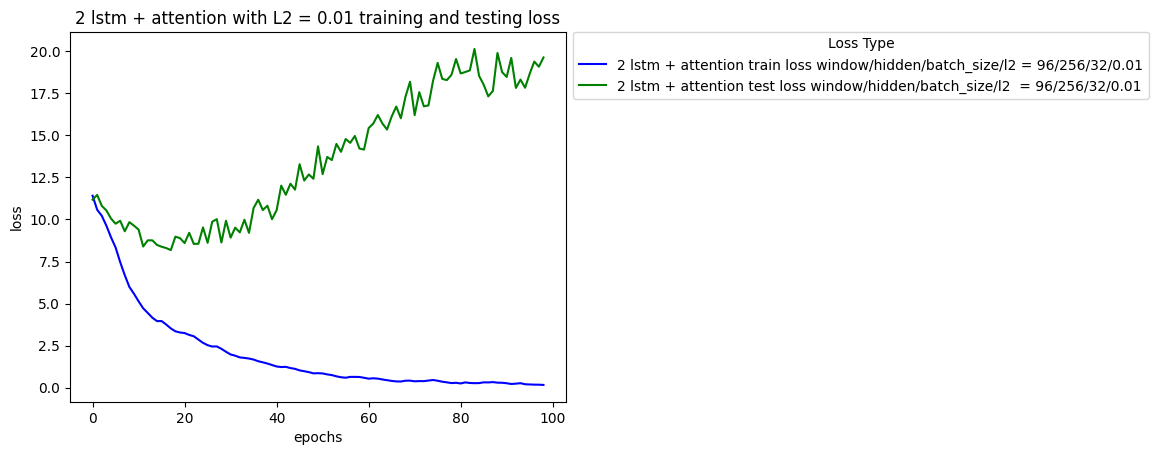

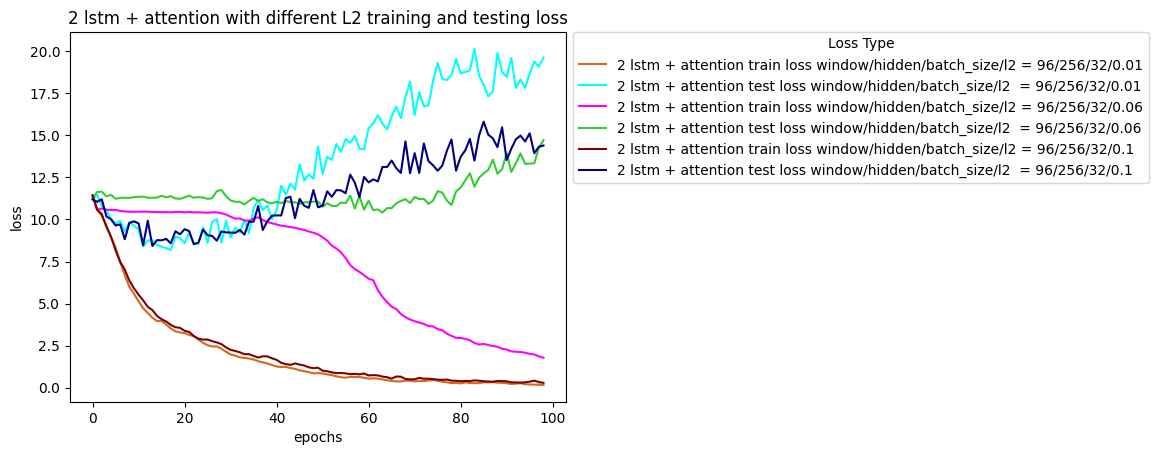

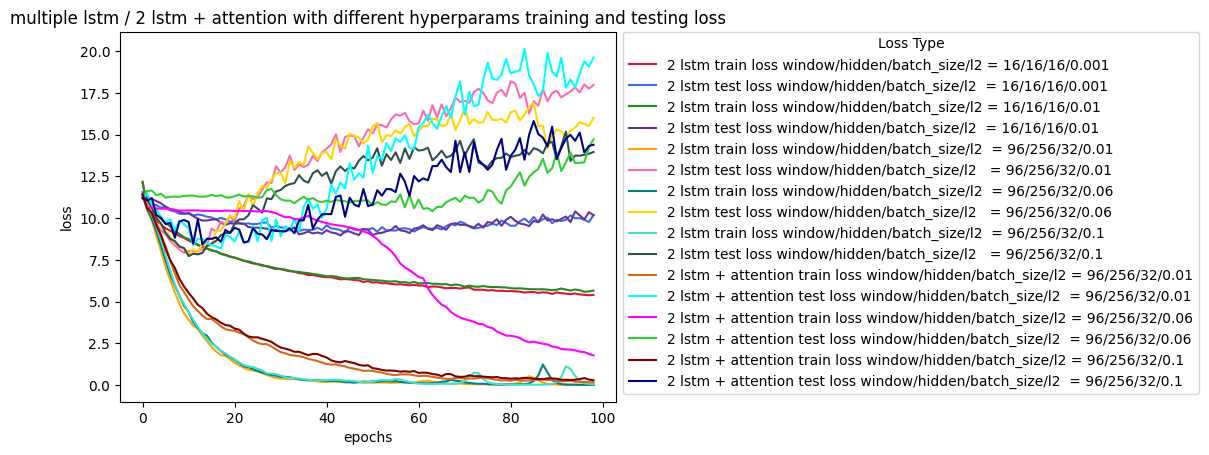

In [287]:
# quick plots
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_losses and test_losses are lists or arrays of loss values
sns.lineplot(data=att_train_losses_01, label='2 lstm + attention train loss window/hidden/batch_size/l2 = 96/256/32/0.01',color='b')
sns.lineplot(data=att_test_losses_01, label='2 lstm + attention test loss window/hidden/batch_size/l2  = 96/256/32/0.01',color='g')

# print(att_train_losses_06)
# print(att_test_losses_06)

# Adding legends, labels and title
plt.legend(title='Loss Type', loc='upper left', bbox_to_anchor=(1, 1.02), frameon=True)
plt.xlabel('epochs')  # Assuming each point represents an epoch
plt.ylabel('loss')
plt.title('2 lstm + attention with L2 = 0.01 training and testing loss')
plt.savefig('my_plot5.png', bbox_inches='tight')
plt.show()


sns.lineplot(data=att_train_losses_01, label='2 lstm + attention train loss window/hidden/batch_size/l2 = 96/256/32/0.01',color='#D2691E')
sns.lineplot(data=att_test_losses_01, label='2 lstm + attention test loss window/hidden/batch_size/l2  = 96/256/32/0.01',color='#00FFFF')
sns.lineplot(data=att_train_losses_06, label='2 lstm + attention train loss window/hidden/batch_size/l2 = 96/256/32/0.06',color='#FF00FF')
sns.lineplot(data=att_test_losses_06, label='2 lstm + attention test loss window/hidden/batch_size/l2  = 96/256/32/0.06',color='#32CD32')
sns.lineplot(data=att_train_losses_1, label='2 lstm + attention train loss window/hidden/batch_size/l2 = 96/256/32/0.1',color='#800000')
sns.lineplot(data=att_test_losses_1, label='2 lstm + attention test loss window/hidden/batch_size/l2  = 96/256/32/0.1',color='#000080')

plt.legend(title='Loss Type', loc='upper left', bbox_to_anchor=(1, 1.02), frameon=True)
plt.xlabel('epochs')  # Assuming each point represents an epoch
plt.ylabel('loss')
plt.title('2 lstm + attention with different L2 training and testing loss')
plt.savefig('my_plot6.png', bbox_inches='tight')
plt.show()

sns.lineplot(data=base_train_losses_001, label='2 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.001',color='#DC143C')
sns.lineplot(data=base_test_losses_001, label='2 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.001',color='#4169E1')
sns.lineplot(data=base_train_losses_01, label='2 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.01',color='#228B22')
sns.lineplot(data=base_test_losses_01, label='2 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.01',color='#663399')
sns.lineplot(data=fine_train_losses_01, label='2 lstm train loss window/hidden/batch_size/l2  = 96/256/32/0.01',color='#FFA500')
sns.lineplot(data=fine_test_losses_01, label='2 lstm test loss window/hidden/batch_size/l2   = 96/256/32/0.01',color='#FF69B4')
sns.lineplot(data=fine_train_losses_06, label='2 lstm train loss window/hidden/batch_size/l2  = 96/256/32/0.06',color='#008080')
sns.lineplot(data=fine_test_losses_06, label='2 lstm test loss window/hidden/batch_size/l2   = 96/256/32/0.06',color='#FFD700')
sns.lineplot(data=fine_train_losses_1, label='2 lstm train loss window/hidden/batch_size/l2  = 96/256/32/0.1',color='#40E0D0')
sns.lineplot(data=fine_test_losses_1, label='2 lstm test loss window/hidden/batch_size/l2   = 96/256/32/0.1',color='#2F4F4F')
sns.lineplot(data=att_train_losses_01, label='2 lstm + attention train loss window/hidden/batch_size/l2 = 96/256/32/0.01',color='#D2691E')
sns.lineplot(data=att_test_losses_01, label='2 lstm + attention test loss window/hidden/batch_size/l2  = 96/256/32/0.01',color='#00FFFF')
sns.lineplot(data=att_train_losses_06, label='2 lstm + attention train loss window/hidden/batch_size/l2 = 96/256/32/0.06',color='#FF00FF')
sns.lineplot(data=att_test_losses_06, label='2 lstm + attention test loss window/hidden/batch_size/l2  = 96/256/32/0.06',color='#32CD32')
sns.lineplot(data=att_train_losses_1, label='2 lstm + attention train loss window/hidden/batch_size/l2 = 96/256/32/0.1',color='#800000')
sns.lineplot(data=att_test_losses_1, label='2 lstm + attention test loss window/hidden/batch_size/l2  = 96/256/32/0.1',color='#000080')

# Adding legends, labels and title
plt.legend(title='Loss Type', loc='upper left', bbox_to_anchor=(1, 1.02), frameon=True)
plt.xlabel('epochs')  # Assuming each point represents an epoch
plt.ylabel('loss')
plt.title('multiple lstm / 2 lstm + attention with different hyperparams training and testing loss')
plt.savefig('my_plot7.png', bbox_inches='tight')

plt.show()

In [254]:
# batch_size for training network
batch_size = 64

# split size of test/train data
split_size = 0.1

# hyperparameters for fine-tuning
    # window_size = sliding window on time-sequence data for input
    # skip steps = steps the window slides each time
    # hidden_size = hidden units of lstm layer(s)
    # conv_channels = number of channels in the first conv layer (multiplied by 2 every next layer)
    # nr_layers = number of lstm layers stacked after each other
hyperparams = dict(
    window_size = [128],
    skip_steps = [16],
    hidden_size = [256],
    nr_layers = [2],
    l2 = [0.01, 0.06, 0.1]
)
# sets of combinations of hparams
hyperparam_value_sets = product(*[value for value in hyperparams.values()])

In [255]:
# Loop through different combinations of the hyperparameters
count = 1
for run_id, (window_size, skip_steps, hidden_size, nr_layers, l2) in enumerate(hyperparam_value_sets):
    # tensorboard summary writer
    writer = SummaryWriter(f'runs/E_window_size={window_size}_hidden_size={hidden_size}_l2={l2}')
    # writer = SummaryWriter(f'drive/MyDrive/colab_outputs/lstm_bach/runs/window_size={window_size}_hidden_size={hidden_size}_l2={l2}')

    # Split data in train and test, scale, create datasets and create dataloaders
    train_loader, test_loader = createDataLoaders(voices, encoded_voices, split_size, window_size, skip_steps, batch_size)

    # some informational print statements
    print("\nNew run window/hidden/l2/batch_size:", window_size, "/", hidden_size, "/", l2, "/", batch_size)
    data = next(iter(train_loader))
    print("Input size:", data["x"].size(), 
        "- Output size:[", data["y1"].size(), data["y2"].size(), data["y3"].size(), data["y4"].size(), "]\n",
        "TRAIN batches:", len(train_loader), 
        "- TEST batches:", len(test_loader) if test_loader else "Not available")
    # Input/output dimensions
    input_size = encoded_voices.shape[1]
    output_sizes = [data["y1"].size(1), data["y2"].size(1), data["y3"].size(1), data["y4"].size(1)]

    print("Input size:",input_size, "Output size:",output_sizes)
    # create model
    lstm_model = LSTM_model(input_size, output_sizes, hidden_size, nr_layers, batch_size)

    # loss function and optimizer
    #   Output of each head is multi-class classification -> cross entropy
    loss_func = nn.CrossEntropyLoss()
    # AdamW = Adam with fixed weight decay (weight decay performed after controlling parameter-wise step size)
    optimizer = optim.AdamW(lstm_model.parameters(), lr=0.001, weight_decay=l2)
    scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=750)
    
    # to gpu if possible
    lstm_model = lstm_model.to(device)
    
    # training loop
    epochs = 100
    
    # In this example we should not use a stateful lstm, as the next samples (subsequent sliding windows) do not follow directly from the current.
    # This is only the case when the first sample is (for Ex.) [1:10] which is the first window, and [11:20] the next, and so on.
    # With our data it would be: [1:10] and the next [2:11]. Target value does not matter necessarily. 
    # More explanation: https://stackoverflow.com/questions/58276337/proper-way-to-feed-time-series-data-to-stateful-lstm
    #   unfortunately I implemented stateful before knowing these in and outs.
    # One possible way to use stateful is to use window_size = 1
    stateful = True
    train_losses, test_losses = training(lstm_model, train_loader, test_loader, epochs, optimizer, loss_func, scheduler, stateful, writer)

    if count == 1:
        fine2_train_losses_01 = train_losses
        fine2_test_losses_01 = test_losses
    elif count == 2:
        fine2_train_losses_06 = train_losses
        fine2_test_losses_06 = test_losses
    else:
        fine2_train_losses_1 = train_losses
        fine2_test_losses_1 = test_losses
    
    count+=1
    # flush tensorboard writer
    writer.flush()


New run window/hidden/l2/batch_size: 128 / 256 / 0.01 / 64
Input size: torch.Size([64, 128, 20]) - Output size:[ torch.Size([64, 22]) torch.Size([64, 27]) torch.Size([64, 23]) torch.Size([64, 26]) ]
 TRAIN batches: 52 - TEST batches: 4
Input size: 20 Output size: [22, 27, 23, 26]
LSTM initialized with 20 input size, 256 hidden layer size, 2 number of LSTM layers, and an output size of [22, 27, 23, 26]


Epoch 99: 100%|██████████| 99/99 [35:45<00:00, 21.67s/it, train_loss=0.365, test_loss=18.3] 



New run window/hidden/l2/batch_size: 128 / 256 / 0.06 / 64
Input size: torch.Size([64, 128, 20]) - Output size:[ torch.Size([64, 22]) torch.Size([64, 27]) torch.Size([64, 23]) torch.Size([64, 26]) ]
 TRAIN batches: 52 - TEST batches: 4
Input size: 20 Output size: [22, 27, 23, 26]
LSTM initialized with 20 input size, 256 hidden layer size, 2 number of LSTM layers, and an output size of [22, 27, 23, 26]


Epoch 99: 100%|██████████| 99/99 [32:39<00:00, 19.80s/it, train_loss=0.287, test_loss=17.3] 



New run window/hidden/l2/batch_size: 128 / 256 / 0.1 / 64
Input size: torch.Size([64, 128, 20]) - Output size:[ torch.Size([64, 22]) torch.Size([64, 27]) torch.Size([64, 23]) torch.Size([64, 26]) ]
 TRAIN batches: 52 - TEST batches: 4
Input size: 20 Output size: [22, 27, 23, 26]
LSTM initialized with 20 input size, 256 hidden layer size, 2 number of LSTM layers, and an output size of [22, 27, 23, 26]


Epoch 99: 100%|██████████| 99/99 [44:20<00:00, 26.87s/it, train_loss=0.0279, test_loss=15.7] 


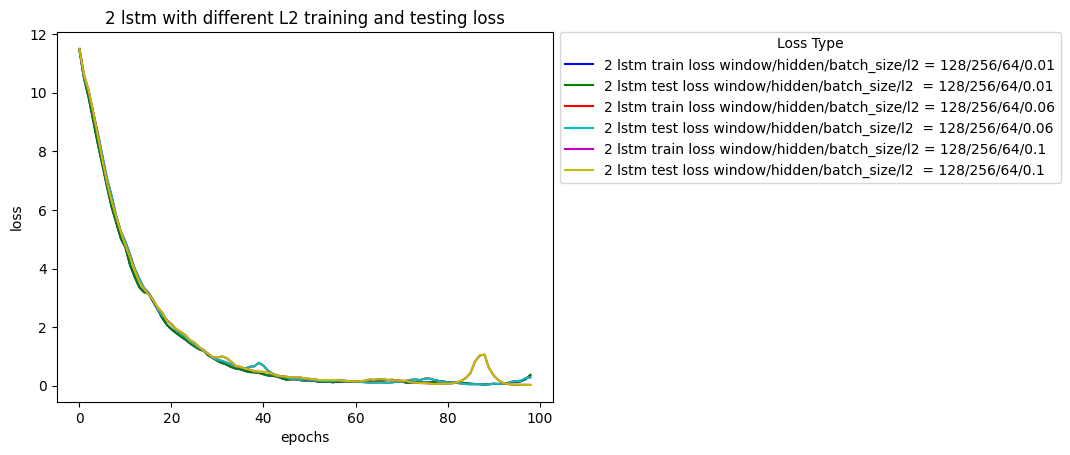

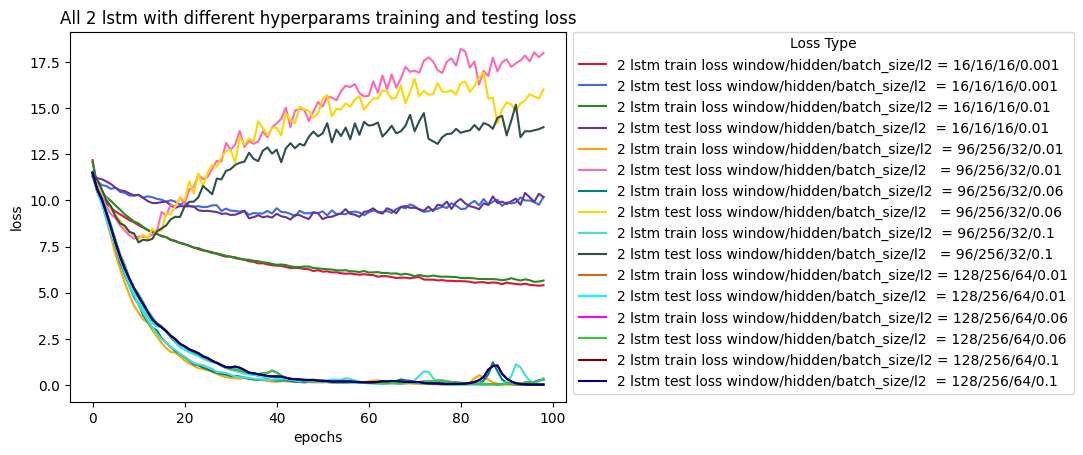

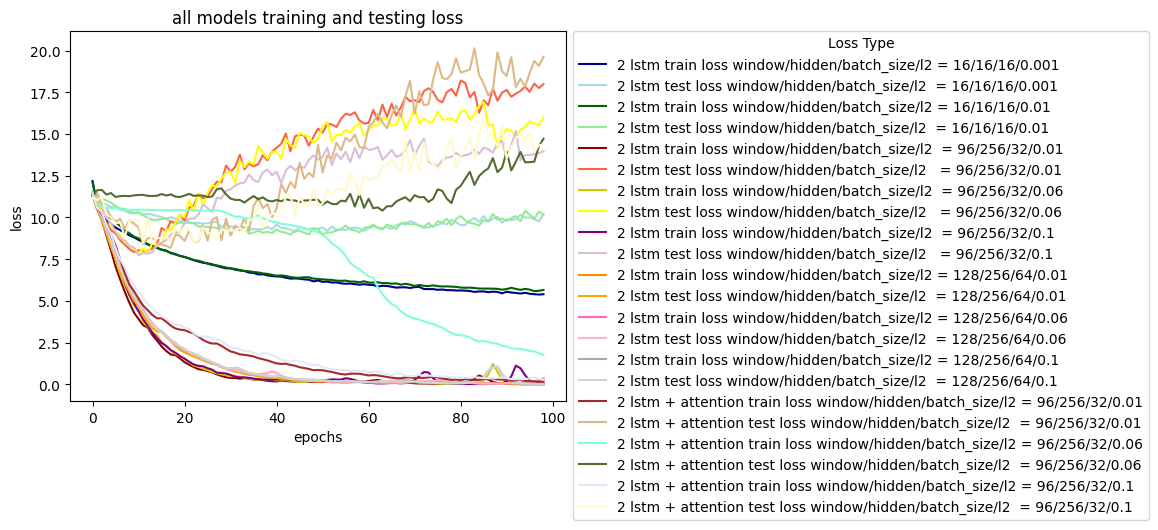

In [288]:
# quick plots
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_losses and test_losses are lists or arrays of loss values
sns.lineplot(data=fine2_train_losses_01, label='2 lstm train loss window/hidden/batch_size/l2 = 128/256/64/0.01',color='b')
sns.lineplot(data=fine2_train_losses_01, label='2 lstm test loss window/hidden/batch_size/l2  = 128/256/64/0.01',color='g')
sns.lineplot(data=fine2_train_losses_06, label='2 lstm train loss window/hidden/batch_size/l2 = 128/256/64/0.06',color='r')
sns.lineplot(data=fine2_train_losses_06, label='2 lstm test loss window/hidden/batch_size/l2  = 128/256/64/0.06',color='c')
sns.lineplot(data=fine2_train_losses_1, label='2 lstm train loss window/hidden/batch_size/l2 = 128/256/64/0.1',color='m')
sns.lineplot(data=fine2_train_losses_1, label='2 lstm test loss window/hidden/batch_size/l2  = 128/256/64/0.1',color='y')

# Adding legends, labels and title
plt.legend(title='Loss Type', loc='upper left', bbox_to_anchor=(1, 1.02), frameon=True)
plt.xlabel('epochs')  # Assuming each point represents an epoch
plt.ylabel('loss')
plt.title('2 lstm with different L2 training and testing loss')
plt.savefig('my_plot8.png', bbox_inches='tight')
plt.show()

sns.lineplot(data=base_train_losses_001, label='2 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.001',color='#DC143C')
sns.lineplot(data=base_test_losses_001, label='2 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.001',color='#4169E1')
sns.lineplot(data=base_train_losses_01, label='2 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.01',color='#228B22')
sns.lineplot(data=base_test_losses_01, label='2 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.01',color='#663399')
sns.lineplot(data=fine_train_losses_01, label='2 lstm train loss window/hidden/batch_size/l2  = 96/256/32/0.01',color='#FFA500')
sns.lineplot(data=fine_test_losses_01, label='2 lstm test loss window/hidden/batch_size/l2   = 96/256/32/0.01',color='#FF69B4')
sns.lineplot(data=fine_train_losses_06, label='2 lstm train loss window/hidden/batch_size/l2  = 96/256/32/0.06',color='#008080')
sns.lineplot(data=fine_test_losses_06, label='2 lstm test loss window/hidden/batch_size/l2   = 96/256/32/0.06',color='#FFD700')
sns.lineplot(data=fine_train_losses_1, label='2 lstm train loss window/hidden/batch_size/l2  = 96/256/32/0.1',color='#40E0D0')
sns.lineplot(data=fine_test_losses_1, label='2 lstm test loss window/hidden/batch_size/l2   = 96/256/32/0.1',color='#2F4F4F')
sns.lineplot(data=fine2_train_losses_01, label='2 lstm train loss window/hidden/batch_size/l2 = 128/256/64/0.01',color='#D2691E')
sns.lineplot(data=fine2_train_losses_01, label='2 lstm test loss window/hidden/batch_size/l2  = 128/256/64/0.01',color='#00FFFF')
sns.lineplot(data=fine2_train_losses_06, label='2 lstm train loss window/hidden/batch_size/l2 = 128/256/64/0.06',color='#FF00FF')
sns.lineplot(data=fine2_train_losses_06, label='2 lstm test loss window/hidden/batch_size/l2  = 128/256/64/0.06',color='#32CD32')
sns.lineplot(data=fine2_train_losses_1, label='2 lstm train loss window/hidden/batch_size/l2 = 128/256/64/0.1',color='#800000')
sns.lineplot(data=fine2_train_losses_1, label='2 lstm test loss window/hidden/batch_size/l2  = 128/256/64/0.1',color='#000080')

# Adding legends, labels and title
plt.legend(title='Loss Type', loc='upper left', bbox_to_anchor=(1, 1.02), frameon=True)
plt.xlabel('epochs')  # Assuming each point represents an epoch
plt.ylabel('loss')
plt.title('All 2 lstm with different hyperparams training and testing loss')
plt.savefig('my_plot9.png', bbox_inches='tight')
plt.show()

sns.lineplot(data=base_train_losses_001, label='2 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.001',color='#00008B')
sns.lineplot(data=base_test_losses_001, label='2 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.001',color='#ADD8E6')
sns.lineplot(data=base_train_losses_01, label='2 lstm train loss window/hidden/batch_size/l2 = 16/16/16/0.01',color='#006400')
sns.lineplot(data=base_test_losses_01, label='2 lstm test loss window/hidden/batch_size/l2  = 16/16/16/0.01',color='#90EE90')
sns.lineplot(data=fine_train_losses_01, label='2 lstm train loss window/hidden/batch_size/l2  = 96/256/32/0.01',color='#8B0000')
sns.lineplot(data=fine_test_losses_01, label='2 lstm test loss window/hidden/batch_size/l2   = 96/256/32/0.01',color='#FF6347')
sns.lineplot(data=fine_train_losses_06, label='2 lstm train loss window/hidden/batch_size/l2  = 96/256/32/0.06',color='#CCCC00')
sns.lineplot(data=fine_test_losses_06, label='2 lstm test loss window/hidden/batch_size/l2   = 96/256/32/0.06',color='#FFFF00')
sns.lineplot(data=fine_train_losses_1, label='2 lstm train loss window/hidden/batch_size/l2  = 96/256/32/0.1',color='#800080')
sns.lineplot(data=fine_test_losses_1, label='2 lstm test loss window/hidden/batch_size/l2   = 96/256/32/0.1',color='#D8BFD8')
sns.lineplot(data=fine2_train_losses_01, label='2 lstm train loss window/hidden/batch_size/l2 = 128/256/64/0.01',color='#FF8C00')
sns.lineplot(data=fine2_train_losses_01, label='2 lstm test loss window/hidden/batch_size/l2  = 128/256/64/0.01',color='#FFA500')
sns.lineplot(data=fine2_train_losses_06, label='2 lstm train loss window/hidden/batch_size/l2 = 128/256/64/0.06',color='#FF69B4')
sns.lineplot(data=fine2_train_losses_06, label='2 lstm test loss window/hidden/batch_size/l2  = 128/256/64/0.06',color='#FFB6C1')
sns.lineplot(data=fine2_train_losses_1, label='2 lstm train loss window/hidden/batch_size/l2 = 128/256/64/0.1',color='#A9A9A9')
sns.lineplot(data=fine2_train_losses_1, label='2 lstm test loss window/hidden/batch_size/l2  = 128/256/64/0.1',color='#D3D3D3')
sns.lineplot(data=att_train_losses_01, label='2 lstm + attention train loss window/hidden/batch_size/l2 = 96/256/32/0.01',color='#A52A2A')
sns.lineplot(data=att_test_losses_01, label='2 lstm + attention test loss window/hidden/batch_size/l2  = 96/256/32/0.01',color='#DEB887')
sns.lineplot(data=att_train_losses_06, label='2 lstm + attention train loss window/hidden/batch_size/l2 = 96/256/32/0.06',color='#7FFFD4')
sns.lineplot(data=att_test_losses_06, label='2 lstm + attention test loss window/hidden/batch_size/l2  = 96/256/32/0.06',color='#556B2F')
sns.lineplot(data=att_train_losses_1, label='2 lstm + attention train loss window/hidden/batch_size/l2 = 96/256/32/0.1',color='#E6E6FA')
sns.lineplot(data=att_test_losses_1, label='2 lstm + attention test loss window/hidden/batch_size/l2  = 96/256/32/0.1',color='#FFFACD')
# Adding legends, labels and title
plt.legend(title='Loss Type', loc='upper left', bbox_to_anchor=(1, 1.02), frameon=True)
plt.xlabel('epochs')  # Assuming each point represents an epoch
plt.ylabel('loss')
plt.title('all models training and testing loss')
plt.savefig('my_plot10.png', bbox_inches='tight')

plt.show()

# Generate music using one of the models

### Function to predict x next notes

In [264]:
def predictNextNotes(input, steps, lstm_model, voices, scaler):
    # predicted notes
    predicted_notes = np.zeros((1,4))

    # all unique notes for each voice
    uniques = findUniques(voices)

    # prepare input
    input = torch.tensor(input, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        for i in range(steps):
            # print(input.shape)
            pred1, pred2, pred3, pred4 = lstm_model(input, stateful=False)
            # print(output)
            pred1 = pred1.detach().numpy().squeeze()
            pred2 = pred2.detach().numpy().squeeze()
            pred3 = pred3.detach().numpy().squeeze()
            pred4 = pred4.detach().numpy().squeeze()

            # get the indices with highest value from model forward output
            note_voice1 = uniques[0][np.argmax(pred1)]
            note_voice2 = uniques[1][np.argmax(pred2)]
            note_voice3 = uniques[2][np.argmax(pred3)]
            note_voice4 = uniques[3][np.argmax(pred4)]
            # print(note_voice1, note_voice2, note_voice3, note_voice4)

            # add to array and inverse scale
            next_notes = np.array([note_voice1, note_voice2, note_voice3, note_voice4])
            next_notes_invscaled = scaler.inverse_transform(next_notes.reshape(1, -1))
            # print(next_notes_invscaled)
            predicted_notes = np.concatenate((predicted_notes, next_notes_invscaled), axis = 0)
            # print(predicted_notes)

            # change input
            # drop oldest notes
            input = input[0][1:]
            # concat predicted notes
            input = torch.cat((input, torch.Tensor(next_notes).unsqueeze(0)))
            input = input.unsqueeze(0)

    return(predicted_notes.astype(np.int32)[1:])

## Load model and generate new notes

In [26]:
# initialize model
model = LSTM_model(input_size = 4, output_size = 98, hidden_size = 256, num_layers = 2, batch_size = 32, channels = 8)
# load model file
model.load_state_dict(torch.load("models/model96256.pth", map_location=device))
model = lstm_model

# load data, 4 voices of instruments
voices = np.loadtxt("input.txt")

# Train/test split (needed for correct scaling of new data)
dataset_size = len(voices[:,])
indices = list(range(dataset_size))
split = int(np.floor((1 - split_size) * dataset_size))
train_indices = indices[:split]
# create split in data
train_voices = voices[train_indices, :]

# fit the scaler to the train data
scaler = StandardScaler()
scaler.fit(train_voices)
# scale voices
voices = scaler.transform(voices)
train_voices = scaler.transform(train_voices)

# take last sliding window in data and infer from there
input = train_voices[-window_size:]
steps = 1500
new_music = predictNextNotes(input, steps, model, voices, scaler)

# save new music
np.savetxt(fname = "output/output.txt", X = new_music, fmt = "%d")

NameError: name 'model' is not defined

## Create a midi files from generated music (output and complete fugue)

In [ ]:
# initialize fluidsynth with soundfont
fluidsynth.init("soundfonts/040_Florestan_String_Quartet.sf2", "salsa")

# load original music
original = np.loadtxt("input.txt")

# load network output music
output = np.loadtxt("output/output.txt")

# concatenate
complete = np.concatenate((original, output), axis = 0)

# create midi for output and comlete (original + output)
for run, voices in enumerate([output, complete]):
    # create 4 tracks for the 4 voices
    encoded_voices = [Track(), Track(), Track(), Track()] 
    
    # loop through the generated voices
    for i, notes in enumerate([voices[:,0], voices[:,1], voices[:,2], voices[:,3]]):
        # initialize as impossible note
        last_note = -1
        count = 1
        for j, note in enumerate(notes):
            if note:
                if ((note == last_note) or (j == 0)):
                    # same note as previous note
                    count += 1
                    last_note = note
                    
                    if (j + count > len(notes)):
                        # current note reaches end of file
                        n = Note()
                        n.from_int(int(last_note))
                        b = Bar()
                        b.place_notes(n, 16/count)
                        encoded_voices[i].add_bar(b)
                else:
                    # different note encountered
                    # add previous note with its duration to track
                    n = Note()
                    n.from_int(int(last_note))
                    b = Bar()
                    
                    # 8 should be 1/2 -> 2
                    # 16 should be 1 -> 1
                    # 32 should be 2 -> 0.5
                    b.place_notes(n, duration = 16/count)
                    encoded_voices[i].add_bar(b)
                    
                    # reset
                    count = 1
                    last_note = note
            else:
                # current note = 0, means a pause (silence)
                b = Bar()
                b.place_rest(16)
                encoded_voices[i].add_bar(b)

    output_composition = Composition()
    output_composition.add_track(encoded_voices[0])
    output_composition.add_track(encoded_voices[1])
    output_composition.add_track(encoded_voices[2])
    output_composition.add_track(encoded_voices[3])

    if (run == 0):
        midi_file_out.write_Composition("output/output.midi", output_composition)
    else:
        midi_file_out.write_Composition("output/complete.midi", output_composition)


## Create mp3


In [ ]:
%%bash
timidity output/output.midi -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 320k output/output.mp3
timidity output/complete.midi -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 320k output/complete.mp3

Playing output/output.midi
MIDI file: output/output.midi
Format: 1  Tracks: 4  Divisions: 72
Sequence: Untitled
Track name: Untitled
Track name: Untitled
Track name: Untitled
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubbe